In [1]:
# Dependencies and Setup
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import hvplot.pandas

# Files to Load
data_2010_2019 = Path("Crime_Data_from_2010_to_2019 (1).csv")
data_2020_2023 = Path("Crime_Data_from_2020_to_Present_20231016.csv")

# Read data(2010-2019) and data (2020- present)Data File and store into Pandas DataFrames
pre_covid_data = pd.read_csv(data_2010_2019)
post_covid_data = pd.read_csv(data_2020_2023)

# Combine the data into a single dataset.  
Data_complete = pd.concat([pre_covid_data, post_covid_data], ignore_index=True)
Data_complete.head()

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON,AREA
0,1307355,02/20/2010 12:00:00 AM,02/20/2010 12:00:00 AM,1350,13.0,Newton,1385,2,900,VIOLATION OF COURT ORDER,...,Adult Arrest,900.0,NaN,NaN,NaN,300 E GAGE AV,NaN,33.9825,-118.2695,NaN
1,11401303,09/13/2010 12:00:00 AM,09/12/2010 12:00:00 AM,45,14.0,Pacific,1485,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",...,Invest Cont,740.0,NaN,NaN,NaN,SEPULVEDA BL,MANCHESTER AV,33.9599,-118.3962,NaN
2,70309629,08/09/2010 12:00:00 AM,08/09/2010 12:00:00 AM,1515,13.0,Newton,1324,2,946,OTHER MISCELLANEOUS CRIME,...,Invest Cont,946.0,NaN,NaN,NaN,1300 E 21ST ST,NaN,34.0224,-118.2524,NaN
3,90631215,01/05/2010 12:00:00 AM,01/05/2010 12:00:00 AM,150,6.0,Hollywood,646,2,900,VIOLATION OF COURT ORDER,...,Invest Cont,900.0,998.0,NaN,NaN,CAHUENGA BL,HOLLYWOOD BL,34.1016,-118.3295,NaN
4,100100501,01/03/2010 12:00:00 AM,01/02/2010 12:00:00 AM,2100,1.0,Central,176,1,122,"RAPE, ATTEMPTED",...,Invest Cont,122.0,NaN,NaN,NaN,8TH ST,SAN PEDRO ST,34.0387,-118.2488,NaN


In [2]:
# Create a Year column from the dataframe
Data_complete['Crime Year'] = pd.to_datetime(Data_complete['Date Rptd']).dt.year

C:\Users\kekoj\AppData\Local\Temp\ipykernel_5680\975316320.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  Data_complete['Crime Year'] = pd.to_datetime(Data_complete['Date Rptd']).dt.year


In [3]:
# Remove unused columns
Data_complete.drop(Data_complete.columns[[1, 2, 3, 4, 6, 7, 10, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,28]], axis=1, inplace=True)

In [4]:
# Remove NaN entries
Data_complete = Data_complete.dropna()

# Clean data for duplicate crime records
Data_complete = Data_complete.drop_duplicates(subset=['DR_NO'])

# Remove unrecorded victim age data
Data_complete = Data_complete[Data_complete['Vict Age'] > 0]

In [5]:
# Change the name of the columns to complete the data cleaning
Data_complete.rename(columns={
                    'DR_NO':'DR Number',
                    'Crime Year': 'Crime Year',
                    'AREA NAME': 'Area Name',
                    'Crm Cd': 'Crime Code',
                    'Crm Cd Desc':'Type of Crime',
                    'Vict Age': 'Victim Age',
                    'Vict Sex': 'Victim Gender',
                    'Vict Descent': 'Victim Ethnicity',
                    'Premis Desc': 'Scene of Crime',
                    'LAT': 'Latitude',
                    'LON': 'Longitude'
                    
},inplace= True)

# Remove coordinates outside of Los Angeles
Data_complete = Data_complete[(Data_complete['Longitude'] < -108) & (Data_complete['Longitude'] > -128)]
Data_complete = Data_complete[(Data_complete['Latitude'] < 44) & (Data_complete['Latitude'] > 24)]

Data_complete.head()

,DR Number,Area Name,Crime Code,Type of Crime,Victim Age,Victim Gender,Victim Ethnicity,Scene of Crime,Latitude,Longitude,Crime Year
0,1307355,Newton,900,VIOLATION OF COURT ORDER,48,M,H,SINGLE FAMILY DWELLING,33.9825,-118.2695,2010
3,90631215,Hollywood,900,VIOLATION OF COURT ORDER,47,F,W,STREET,34.1016,-118.3295,2010
4,100100501,Central,122,"RAPE, ATTEMPTED",47,F,H,ALLEY,34.0387,-118.2488,2010
5,100100506,Central,442,SHOPLIFTING - PETTY THEFT ($950 & UNDER),23,M,B,DEPARTMENT STORE,34.0480,-118.2577,2010
6,100100508,Central,330,BURGLARY FROM VEHICLE,46,M,H,STREET,34.0389,-118.2643,2010


In [6]:
count = len(Data_complete['DR Number'])
print(count)

2326755


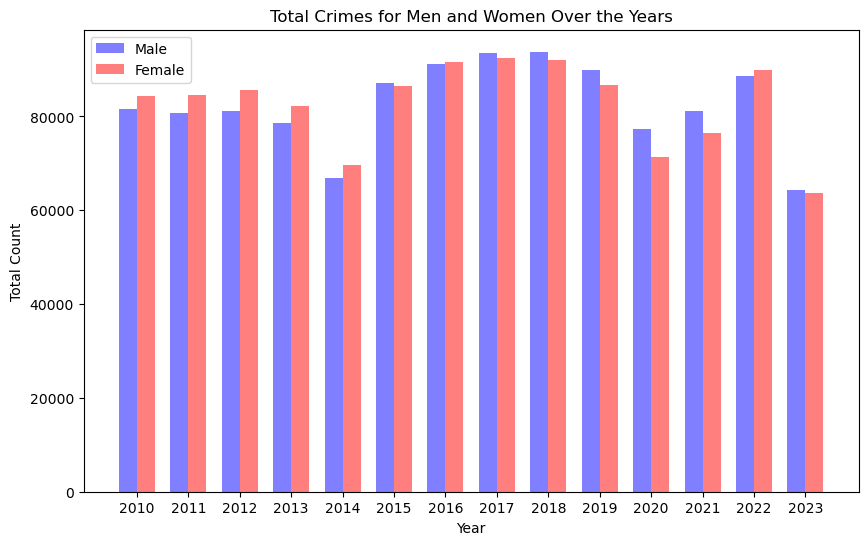

In [8]:
male_data = Data_complete[Data_complete['Victim Gender'] == 'M']
female_data = Data_complete[Data_complete['Victim Gender'] == 'F']

# Calculate the total number of crimes for each gender over the years
male_counts = male_data['Crime Year'].value_counts().sort_index()
female_counts = female_data['Crime Year'].value_counts().sort_index()

# Create a grouped bar chart for both genders
plt.figure(figsize=(10, 6))
bar_width = 0.35  # Width of each bar

x = male_counts.index  # X-axis values (years)

plt.bar(x - bar_width/2, male_counts.values, bar_width, color='blue', alpha=0.5, label='Male')
plt.bar(x + bar_width/2, female_counts.values, bar_width, color='red', alpha=0.5, label='Female')

plt.title('Total Crimes for Men and Women Over the Years')
plt.xlabel('Year')
plt.ylabel('Total Count')
plt.xticks(x)
plt.legend()
plt.show()

In [23]:
import numpy as np
from scipy.stats import ttest_ind_from_stats, ttest_ind
from scipy.special import stdtr

# Calculate the mean and standard deviation for the female group
female_mean = sum(female_counts) / len(female_counts)
std1 = (sum((x - female_mean) ** 2 for x in female_counts) / (len(female_counts) - 1)) ** 0.5
n1 = len(female_counts)

# Calculate the mean and standard deviation for the male group
male_mean = sum(male_counts) / len(male_counts)
std2 = (sum((x - male_mean) ** 2 for x in male_counts) / (len(male_counts) - 1)) ** 0.5
n2 = len(male_counts)

# Perform the t-test
t_stat_from_stats, p_value_from_stats = stats.ttest_ind_from_stats(female_mean, std1, n1, male_mean, std2, n2)

# Output the results
print("T-statistic (from stats):", t_stat_from_stats)
print("P-value (from stats):", p_value_from_stats)


# Set the alpha value
alpha = 0.05  
if p_value_from_stats < alpha:
    print("Reject the null hypothesis (from stats): There is a significant difference between the groups.")
else:
    print("Fail to reject the null hypothesis (from stats): There is no significant difference between the groups.")



T-statistic (from stats): 0.024404718875823357
P-value (from stats): 0.9807161287234315
Fail to reject the null hypothesis (from stats): There is no significant difference between the groups.
